In [1]:
import os
import csv
from tqdm import tqdm
import torch 
from torchvision import transforms
import torch.nn.functional as F
import nibabel as nib
import numpy as np

import matplotlib.pyplot as plt

from monai.networks.nets import BasicUNet

In [2]:
model = BasicUNet(spatial_dims=3, in_channels=1, out_channels=9)
device = torch.device('cpu')
model.to(device)
model_save_name = "best_metric_model_multiclass.pth"
model.load_state_dict(torch.load(model_save_name))

BasicUNet features: (32, 32, 64, 128, 256, 32).


<All keys matched successfully>

In [3]:
# # Utility Function to resize images to 128 cubed volumes
# def resize_vol(in_vol, new_size=(1, 128, 128, 128)):
#     new_vol = np.zeros(new_size)
#     sz = in_vol.shape
#     in_starts = [0] * 3
#     out_starts = [0] * 3
#     in_ends = [sz[0], sz[1], sz[2]]
#     out_ends = [new_size[1], new_size[2], new_size[3]]
#     for i in range(len(sz)):
#         if sz[i] > new_size[i+1]:
#             center = int(np.round(sz[i] / 2))
#             in_starts[i] = center - int(new_size[i+1] / 2)
#             in_ends[i] = center + int(new_size[i+1] / 2)
#         else:
#             center = int(np.floor(new_size[i+1] / 2))
#             offset = int(np.round(sz[i] / 2))
#             if np.mod(sz[i], 2) != 0:
#                 out_starts[i] = center - offset
#                 out_ends[i] = out_starts[i] + sz[i]
#             else:
#                 out_starts[i] = center - offset
#                 out_ends[i] = center + offset

#     new_vol[0, out_starts[0]:out_ends[0], out_starts[1]:out_ends[1], out_starts[2]:out_ends[2]] \
#         = in_vol[in_starts[0]:in_ends[0], in_starts[1]:in_ends[1], in_starts[2]:in_ends[2]]
#     return new_vol

In [4]:
# # Load Volume, resize, and define as tensor
# full_volume = r'\\civmxray1.dhe.duke.edu\justify\Cardiac_APOE\210118-11\02092021\PCD\Results\set3\X2t_iter_cropped.nii'
# full_volume = nib.load(full_volume).get_fdata()[:, :, :, :, 0]
# full_volume_resized = np.zeros((1, 128, 128, 128, full_volume.shape[-1]))
# for t in range(full_volume.shape[-1]):
#     full_volume_resized[:, :, :, :, t] = resize_vol(full_volume[:, :, :, t])
# full_volume_resized = full_volume_resized.swapaxes(1, 2).swapaxes(2, 3)
# full_volume = None
# full_volume_resized = torch.from_numpy(full_volume_resized).cpu().to(torch.float32)
# mean_val = full_volume_resized.mean()
# std_val = full_volume_resized.std()
# full_volume_resized = (full_volume_resized - mean_val) / std_val
# full_volume_resized = full_volume_resized.unsqueeze(0)

In [5]:
# # Display the image using matplotlib to make sure proper formatting
# import matplotlib.pyplot as plt
# img_for_display = full_volume_resized[0, 0, :, :, 82, 0]
# print(img_for_display.shape)

# plt.figure()
# plt.imshow(img_for_display, cmap='gray')
# plt.axis('off')
# plt.show()

In [6]:
# # Segment Each Phase
# full_pred = np.zeros((128, 128, 128, 9, 10), dtype=np.int32)
# i = 0
# with torch.no_grad():
#     model.eval()
#     for i in tqdm(range(full_volume_resized.shape[-1])):
#         pred = model(full_volume_resized[:, :, :, :, :, i])
#         pred = pred.softmax(axis=1).argmax(axis=1)
#         pred = F.one_hot(pred.squeeze()).to(torch.int32)
#         full_pred[:, :, :, :, i] = pred.numpy()

In [7]:
# full_pred.shape

In [8]:
# img_for_display = full_pred[:, :, 82, :, 0]
# img_for_display = np.argmax(img_for_display, axis=2)
# print(img_for_display.shape)
# plt.figure()
# plt.imshow(img_for_display, cmap='gray')
# plt.axis('off')
# plt.show()

In [9]:
# output_file = r'\\civmxray1.dhe.duke.edu\justify\Cardiac_APOE\210118-11\02092021\PCD\Results\set3\all_phases_segmentation.nii'
# nib.save(nib.Nifti1Image(full_pred[:, :, :, :, :], np.eye(4)), output_file)

In [10]:
# output_resized = r'\\civmxray1.dhe.duke.edu\justify\Cardiac_APOE\210118-11\02092021\PCD\Results\set3\all_phases_resized.nii'
# nib.save(nib.Nifti1Image(full_volume_resized.squeeze().squeeze().numpy(), np.eye(4)), output_resized)

## Repeat for all mice

In [11]:
# Get Master List of Files
# master_file_list = r'C:\Users\Alex\Gitlab_repos\Projects\cardiac-apoe-analysis-utils\master_file_list.csv'
master_file_list = r'C:\Users\Alex\Gitlab_repos\Projects\cardiac-apoe-analysis-utils\folder_list.csv'
with open(master_file_list, 'r') as f:
    reader = csv.reader(f)
    file_list = list(reader)

In [12]:
for file in tqdm(file_list):
    # Load Volume, resize, and define as tensor
    full_volume_resized = os.path.join(file[0], 'X2t_iter_cropped_resized.nii')
    full_volume_resized = nib.load(full_volume_resized).get_fdata()
    # full_volume_resized = full_volume_resized.swapaxes(1, 2).swapaxes(2, 3)
    full_volume_resized = torch.from_numpy(full_volume_resized).cpu().to(torch.float32)
    mean_val = full_volume_resized.mean()
    std_val = full_volume_resized.std()
    full_volume_resized = (full_volume_resized - mean_val) / std_val
    full_volume_resized = full_volume_resized.unsqueeze(0).unsqueeze(0)
    
    # Segment Each Phase
    full_pred = np.zeros((128, 128, 128, 9, 10), dtype=np.int32)
    i = 0
    with torch.no_grad():
        model.eval()
        for i in range(full_volume_resized.shape[-1]):
            pred = model(full_volume_resized[:, :, :, :, :, i])
            pred = pred.softmax(axis=1).argmax(axis=1)
            pred = F.one_hot(pred.squeeze()).to(torch.int32)
            full_pred[:, :, :, :, i] = pred.numpy()

    output_file = os.path.join(file[0], 'all_phases_segmentation.nii')
    nib.save(nib.Nifti1Image(full_pred[:, :, :, :, :], np.eye(4)), output_file)
    # print(output_file)
    # break

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]


FileNotFoundError: No such file or no access: '\\civmxray1.dhe.duke.edu\justify\Cardiac_APOE\06052023\230605-1\Results\set1\X2t_iter_cropped_resized.nii'

torch.Size([128, 128])


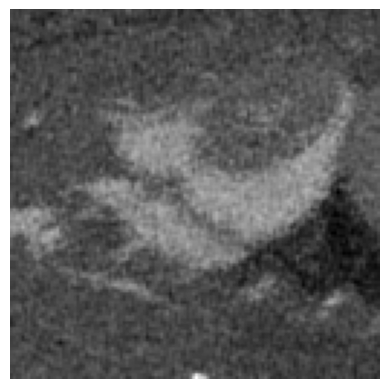

In [34]:
import matplotlib.pyplot as plt
img_for_display = full_volume_resized[0, 0, :, :, 82, 0]
print(img_for_display.shape)

plt.figure()
plt.imshow(img_for_display, cmap='gray')
plt.axis('off')
plt.show()